In [19]:
import numpy as np
from nexusformat.nexus import nxload
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.ticker as ticker
from PIL import Image
from scipy.optimize import curve_fit 
import matplotlib.colors as mcolors
from PIL import ImageDraw
from PIL import ImageFilter

import pyvista as pv
from nexusformat.nexus import nxload


# Switch off interactive mode
pv.set_jupyter_backend('static')
pv.start_xvfb()

# Import the data

In [21]:
a = nxload('lbco125_28K_arr.nxs')

# Choose here the range of data to plot in terms of H, K, L values
dat = a['entry/data'][10.:20., -4.:6., -4.:6.] #full data range
#dat = a['entry/data'][-0.5:0.5, -0.5:0.5, -0.5:0.5] #test data range

# Read the information about the axes from the nexus file
h = dat['Qh']
k = dat['Qk']
l = dat['Ql']
dh = h[1]-h[0]
dk = k[1]-k[0]
dl = l[1]-l[0]
H, K, L = np.meshgrid(h, k, l)
I = dat['v']+0.0001
I = np.swapaxes(I,0,2)

# Plot a segment of the 3D data

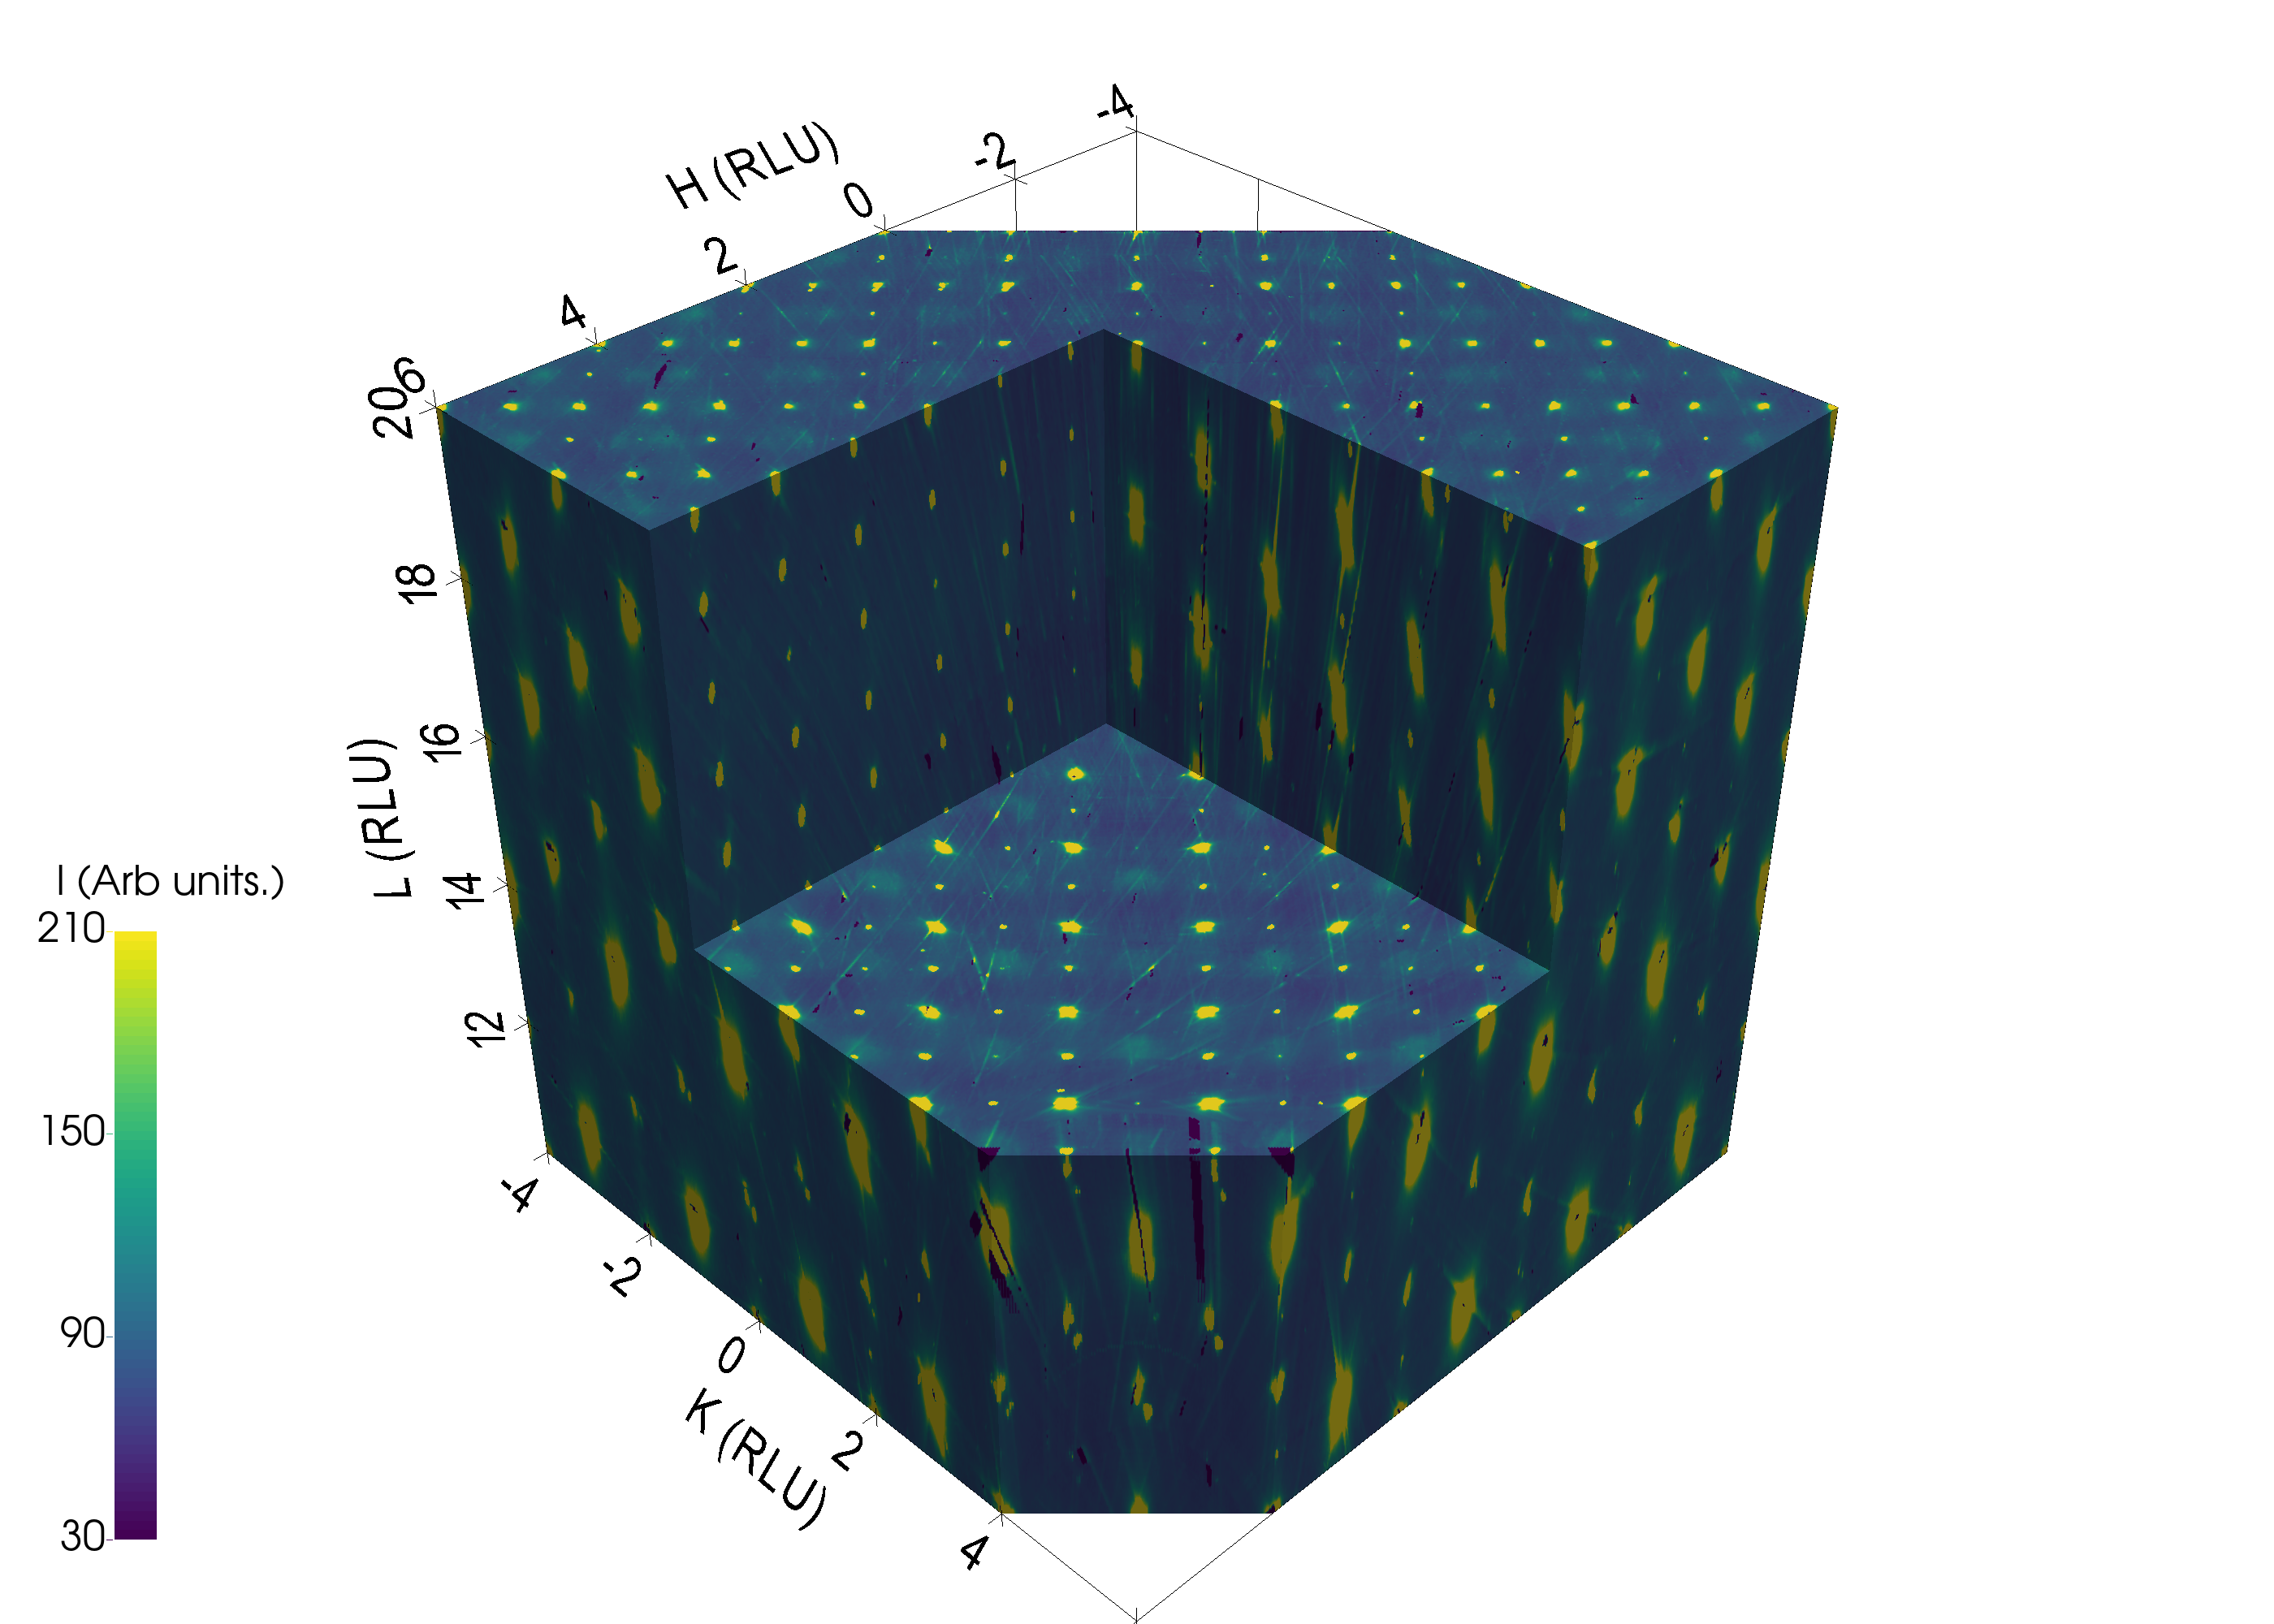

In [22]:
pv.global_theme.font.size = 50

grid = pv.UniformGrid()
grid.dimensions = I.shape

# Edit the spatial reference
grid.origin = (h.min(), k.min(), l.min())  # The bottom left corner of the data set
grid.spacing = (dh, dk, dl)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.point_data["values"] = I.flatten(order="F")  # Flatten the array!

# Clip the edges and create a section from the center
clipped = grid.clip_box(bounds=(0, 10, -0.5, 10, 15., 50))
plane = pv.Plane(center=(5., 5., 0), direction=(-1, -1, 0), i_size=5000, j_size=5000)
clipped = clipped.clip_surface(plane)
plane = pv.Plane(center=(-2.0, -2.0, 0), direction=(1, 1, 0), i_size=5000, j_size=5000)
clipped = clipped.clip_surface(plane)

scalar_bar_args = dict(
    title_font_size=50,
    label_font_size=50,
    color='k',
    n_labels=0,
    fmt="%.1f",
    title='I (Arb units.)',
    height=0.4, width=0.05, vertical=True, position_x=0.05, position_y=0.05
)

clim=(30, 210)
annotations = {val:f"{val:.0f}" for val in np.arange(clim[0], clim[1]+1e-6, 60)}


p = pv.Plotter(window_size=[2800, 2000])


p.add_mesh(clipped, scalar_bar_args=scalar_bar_args, clim=clim, annotations=annotations)
labels = dict(xlabel='H (RLU)', ylabel='K (RLU)', zlabel='L (RLU)')
p.show_grid(**labels, color='k')

p.set_background('white')
p.screenshot('ex_23_cuts.png', return_img=False)

p.show()

# Setup and helper functions for Figure 1

In [23]:
mpl.rc('lines', markersize=4)
colors = [f'C{i}' for i in range(10)]
font = {'size' : 7}
matplotlib.rc('font', **font)

In [24]:
# Helper functions for gradient fill

def zfunc(x, y, fill_color='k', alpha=1.0):
    scale = 10
    x = (x*scale).astype(int)
    y = (y*scale).astype(int)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()

    w, h = xmax-xmin, ymax-ymin
    z = np.empty((h, w, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    print(rgb.shape)
    z[:,:,:3] = rgb

    # Build a z-alpha array which is 1 near the line and 0 at the bottom.
    img = Image.new('L', (w, h), 0)  
    draw = ImageDraw.Draw(img)
    xy = (np.column_stack([x, y]))
    xy -= xmin, ymin
    # Draw a blurred line using PIL
    draw.line(map(tuple, xy.tolist()), fill=255, width=15)
    img = img.filter(ImageFilter.GaussianBlur(radius=100))
    # Convert the PIL image to an array
    zalpha = np.asarray(img).astype(float) 
    zalpha *= alpha/zalpha.max()
    # make the alphas melt to zero at the bottom
    n = zalpha.shape[0] // 4
    zalpha[:n] *= np.linspace(0, 1, n)[:, None]
    z[:,:,-1] = zalpha
    return z

def gradient_fill(x, y, fill_color='k', ax=None, zfunc=None, alpha=1, zorder=1, reverse=False, **kwargs):
    if ax is None:
        ax = plt.gca()

    if zfunc is None:
        h, w = 100, 1
        z = np.empty((h, w, 4), dtype=float)
        rgb = mcolors.colorConverter.to_rgb(fill_color)
        z[:,:,:3] = rgb
        
        if reverse:
            z[:,:,-1] = np.linspace(alpha, 0, h)[:,None]
        else:
            z[:,:,-1] = np.linspace(0, alpha, h)[:,None]
    else:
        z = zfunc(x, y, fill_color=fill_color, alpha=alpha)
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = patches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    ax.autoscale(True)
    return im

# Plot Figure 1

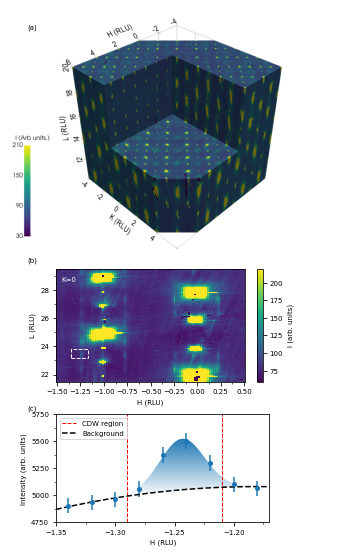

In [25]:
fig = plt.figure(figsize=(4,7.5))
ax1 = fig.add_axes([-0.01, 0.39, 1.18, 0.8])
ax2 = fig.add_axes([0.16, 0.32, 0.82, 0.21])
ax4 = fig.add_axes([0.16, 0.06, 0.74, 0.2])

# Load and plot the 3D image
im = Image.open('./ex_23_cuts.png')
ax1.imshow(im)
# Remove the axes 
ax1.set_axis_off()
    
# Plot the H0L map in panel (b)
a = nxload('lbco125_28K_arr.nxs')
dat = a['entry/data'][21.5:29.5, -.002:.002, -1.5:0.5]

h = -1; k = 0; l = 23.5
mlow = -0.28
mhi = -0.22
plow = 0.18
phi = 0.24

im = ax2.pcolormesh(dat['Qh'], dat['Ql'],  np.reshape(dat['v'],[len(dat['v']), len(dat['v'][0][0])] ), shading='nearest')
im.set_clim([59,220])
ax2.set_xlabel('H (RLU)')
ax2.set_ylabel('L (RLU)')
r2 = patches.Rectangle((h+mlow-0.07,l-0.3),.18,0.6,linewidth=1,ls='--',edgecolor='w',facecolor='none')
ax2.add_patch(r2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(.25))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.125))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.colorbar(im, ax=ax2, label='I (arb. units)')


def p1(x, a, cen, sig):
    return a*np.exp(-((x-cen)**2)/sig)

# Take the h cut
hcut = a['entry/data'][l-0.3:l+0.3, k-0.04:k+0.04, h-0.5:h+0.5].sum(axis=[0,1])
E_, I_ = np.asarray(hcut['Qh']), np.asarray(hcut['v'])

# Fit the background for the -delta peak
choose = np.logical_or( np.logical_and(E_>h+mlow-0.07, E_<h+mlow-0.01), np.logical_and(E_>h+mhi+0.01, E_<h+mhi+0.05) )
choose1 = np.logical_and( E_>h+mlow-0.07, E_<h+mhi+0.05) 
choose2 = np.logical_and( E_>h+mlow-0.01, E_<h+mhi+0.03) 
E2 = E_[choose]
I2 = I_[choose]
E2a = E_[choose1]
I2a = I_[choose1]
fit_minus = np.polyfit(E2,I2,2)

# Fit the -delta peak
x_fit = E2a
y_fit = fit_minus[0]*x_fit**2 + fit_minus[1]*x_fit + fit_minus[2]
y_sub = I2a - y_fit
fit1 = curve_fit(p1, x_fit, y_sub, p0 = [500, -1.24, 0.0005])
x_fine = np.linspace(-1.3, -1.19,100)
y_fine = fit_minus[0]*x_fine**2 + fit_minus[1]*x_fine + fit_minus[2] + p1(x_fine, fit1[0][0], fit1[0][1], fit1[0][2])
x_fit = np.linspace(h+mlow-0.07, h+mhi+0.05,30)
y_fit = fit_minus[0]*x_fit**2 + fit_minus[1]*x_fit + fit_minus[2]

# Plot panel c
ax4.axvline(x=h+mlow-0.01, color='r', ls='--', label='CDW region', linewidth=1)
ax4.axvline(x=h+mhi+0.01, color='r', ls='--', linewidth=1)
gradient_fill(x_fine, y_fine, fill_color=colors[0], ax=ax4, zorder=0)
ax4.fill_between(x_fit, y_fit, color='w', zorder=1)
ax4.plot(x_fit, y_fit, color='k', ls='--', label='Background')
ax4.errorbar(E_, I_, I_**.5, ls='None', marker='o')

ax4.set_xlim(h+mlow-0.07, h+mhi+0.05)
ax4.set_ylim(4750, 5750)
ax4.xaxis.set_major_locator(ticker.MultipleLocator(.05))
ax4.xaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax4.yaxis.set_major_locator(ticker.MultipleLocator(250))
ax4.yaxis.set_minor_locator(ticker.MultipleLocator(125))
ax4.set_xlabel('H (RLU)')
ax4.set_ylabel('Intensity (arb. units)')
ax4.legend(loc='upper left')

# Add the text labels
ax2.text(-1.82, 46.5,'(a)')
ax2.text(-1.82,30,'(b)')
ax2.text(-1.82,19.5,'(c)')
ax2.text(-1.45,28.6,'K=0',color='w')
plt.show()

In [26]:
pip freeze > requirement.txt

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip-compile


Usage:   
  /Users/jsears/opt/anaconda3/envs/workspace/bin/python -m pip <command> [options]

no such option: -c
Note: you may need to restart the kernel to use updated packages.
